In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score,ConfusionMatrixDisplay
)

from imblearn.under_sampling import TomekLinks


In [ ]:
bank_dataset = pd.read_csv('/content/bank-full.csv', sep=';')
bank_dataset

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [ ]:
# Count "unknown" values
unknown_counts = bank_dataset.isin(["unknown"]).sum()
unknown_counts = unknown_counts[unknown_counts > 0]
unknown_counts

,0
job,288
education,1857
contact,13020
poutcome,36959


In [ ]:
# Print percentage
unknown_percent = bank_dataset.isin(["unknown"]).sum() / len(bank_dataset) * 100
print(unknown_percent)

age           0.000000
job           0.637013
marital       0.000000
education     4.107407
default       0.000000
balance       0.000000
housing       0.000000
loan          0.000000
contact      28.798301
day           0.000000
month         0.000000
duration      0.000000
campaign      0.000000
pdays         0.000000
previous      0.000000
poutcome     81.747805
y             0.000000
dtype: float64


/tmp/ipython-input-5-2878179633.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unknown_counts.index, y=unknown_counts.values, palette="viridis")


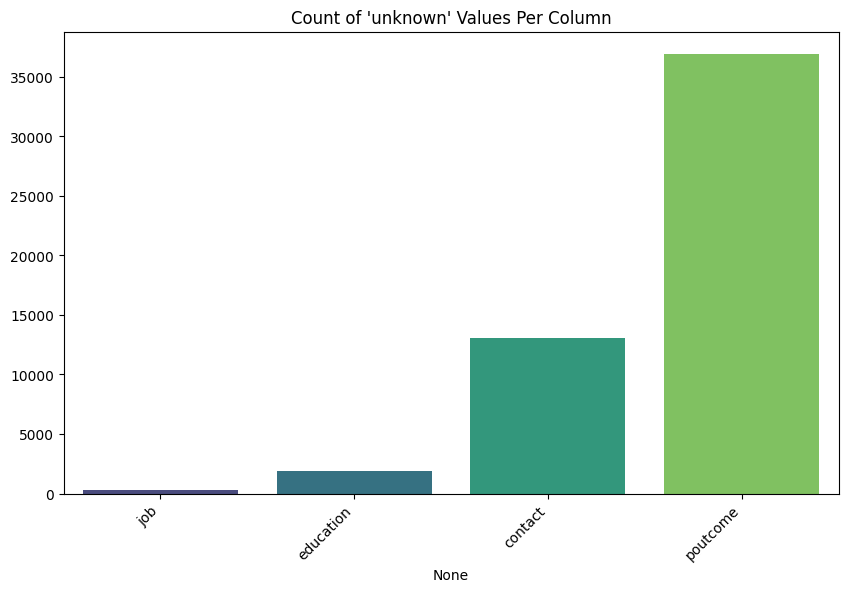

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=unknown_counts.index, y=unknown_counts.values, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Count of 'unknown' Values Per Column")
plt.show()


In [ ]:
# Remove rows with 'unknown' in essential columns
essential_columns = ['job', 'education']
for col in essential_columns:
    bank_dataset = bank_dataset[bank_dataset[col] != "unknown"]

In [ ]:
# Drop high-'unknown' columns
bank_dataset = bank_dataset.drop(columns=['contact', 'poutcome'])

In [ ]:
# Encode categorical columns
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    bank_dataset[col] = le.fit_transform(bank_dataset[col])
    label_encoders[col] = le

In [ ]:
# Encode target
bank_dataset['y'] = bank_dataset['y'].apply(lambda x: 1 if x == 'yes' else 0)

print("Data shape after cleaning:", bank_dataset.shape)


Data shape after cleaning: (43193, 15)


In [ ]:
X = bank_dataset.drop(columns=['y'])
y = bank_dataset['y']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(    X_scaled, y, test_size=0.3, stratify=y, random_state=42       )

In [ ]:
tomek = TomekLinks()
X_train_balanced, y_train_balanced = tomek.fit_resample(X_train, y_train)

/tmp/ipython-input-14-1029424235.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_balanced, palette="viridis")


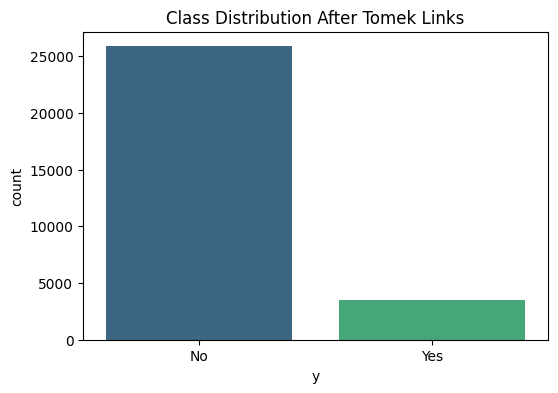

In [ ]:
# Visualize new class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_balanced, palette="viridis")
plt.title("Class Distribution After Tomek Links")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

In [ ]:
# Logistic Regression
log_params = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs'],
    'penalty': ['l2']
}
log_model = GridSearchCV(LogisticRegression(max_iter=500), log_params, cv=5, scoring='roc_auc')
log_model.fit(X_train_balanced, y_train_balanced)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=500),
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring='roc_auc')

In [ ]:
# SVM
svm_params = {
    'C': [1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}
svm_model = GridSearchCV(SVC(probability=True), svm_params, cv=5, scoring='roc_auc')
svm_model.fit(X_train_balanced, y_train_balanced)

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf']},
             scoring='roc_auc')

In [ ]:
# KNN hyperparameter tuning
knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_model = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='roc_auc')
knn_model.fit(X_train_balanced, y_train_balanced)

Best KNN: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}


In [ ]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

In [ ]:
# Random Forest adjusted threshold predictions
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_pred_adjusted_rf = (y_pred_proba_rf >= 0.25).astype(int)

print("\nClassification Report with Adjusted Threshold (0.25):")
print(classification_report(y_test, y_pred_adjusted_rf))



Classification Report with Adjusted Threshold (0.25):
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     11452
           1       0.48      0.78      0.60      1506

    accuracy                           0.88     12958
   macro avg       0.72      0.84      0.76     12958
weighted avg       0.91      0.88      0.89     12958



In [ ]:
print("Best LogReg:", log_model.best_params_)
print("Best SVM:", svm_model.best_params_)
print("Best KNN:", knn_model.best_params_)

Best LogReg: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best KNN: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}


In [ ]:
models = {
    'Logistic Regression': log_model.best_estimator_,
    'SVM': svm_model.best_estimator_,
    'K-Nearest Neighbors': knn_model.best_estimator_,
    'Random Forest': rf_model
}


results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)

    report = classification_report(y_test, y_pred, output_dict=True)
    results.append({
        'Model': name,
        'Accuracy': report['accuracy'],
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1': report['1']['f1-score'],
        'ROC AUC': roc_auc
    })

In [ ]:
# Add adjusted threshold RF results
report_adj = classification_report(y_test, y_pred_adjusted_rf, output_dict=True)
roc_auc_adj = roc_auc_score(y_test, y_pred_proba_rf)

results.append({
    'Model': 'Random Forest (Adj. Thresh)',
    'Accuracy': report_adj['accuracy'],
    'Precision': report_adj['1']['precision'],
    'Recall': report_adj['1']['recall'],
    'F1': report_adj['1']['f1-score'],
    'ROC AUC': roc_auc_adj
})

In [ ]:
results_df = pd.DataFrame(results)
print(results_df)

                         Model  Accuracy  Precision    Recall        F1  \
0          Logistic Regression  0.891496   0.575758  0.252324  0.350877   
1                          SVM  0.897052   0.595556  0.355910  0.445553   
2          K-Nearest Neighbors  0.896357   0.597839  0.330677  0.425823   
3                Random Forest  0.900756   0.617021  0.385126  0.474244   
4  Random Forest (Adj. Thresh)  0.876524   0.480832  0.782869  0.595755   

    ROC AUC  
0  0.869781  
1  0.864140  
2  0.832815  
3  0.919235  
4  0.919235  


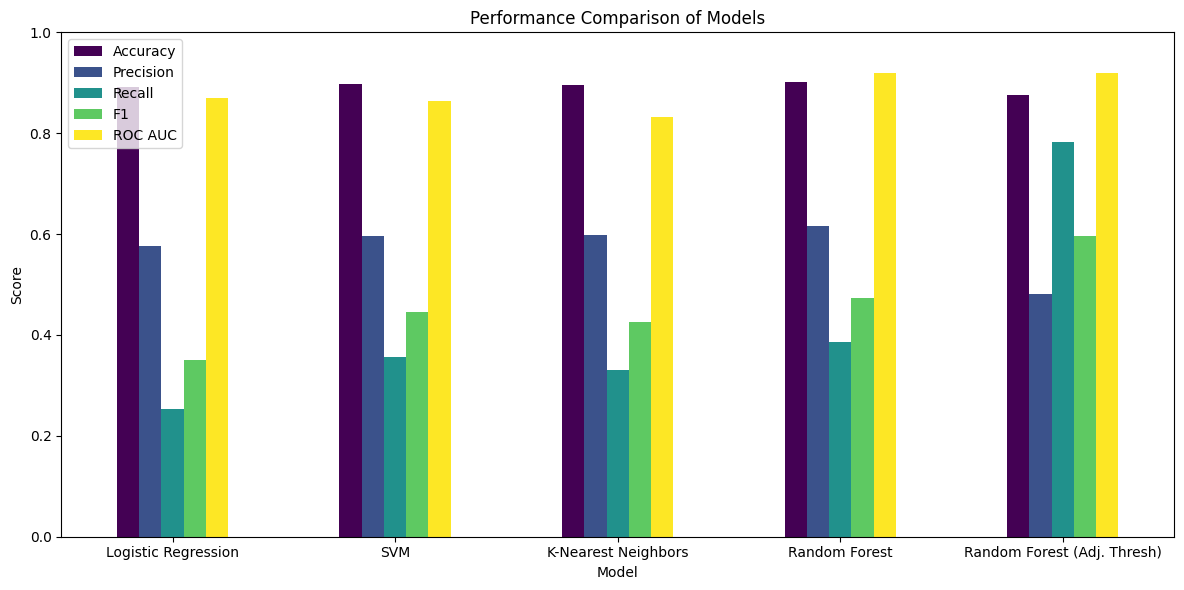

In [ ]:
results_df = pd.DataFrame(results)

# Plot
results_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1", "ROC AUC"]].plot(
    kind='bar', figsize=(12, 6), colormap='viridis')
plt.title("Performance Comparison of Models")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

LogisticRegression(C=0.1, max_iter=500) [[11172   280]
 [ 1126   380]]
SVC(C=10, probability=True) [[11088   364]
 [  970   536]]
KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance') [[11117   335]
 [ 1008   498]]
RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42) [[11092   360]
 [  926   580]]
None [[10179  1273]
 [  327  1179]]


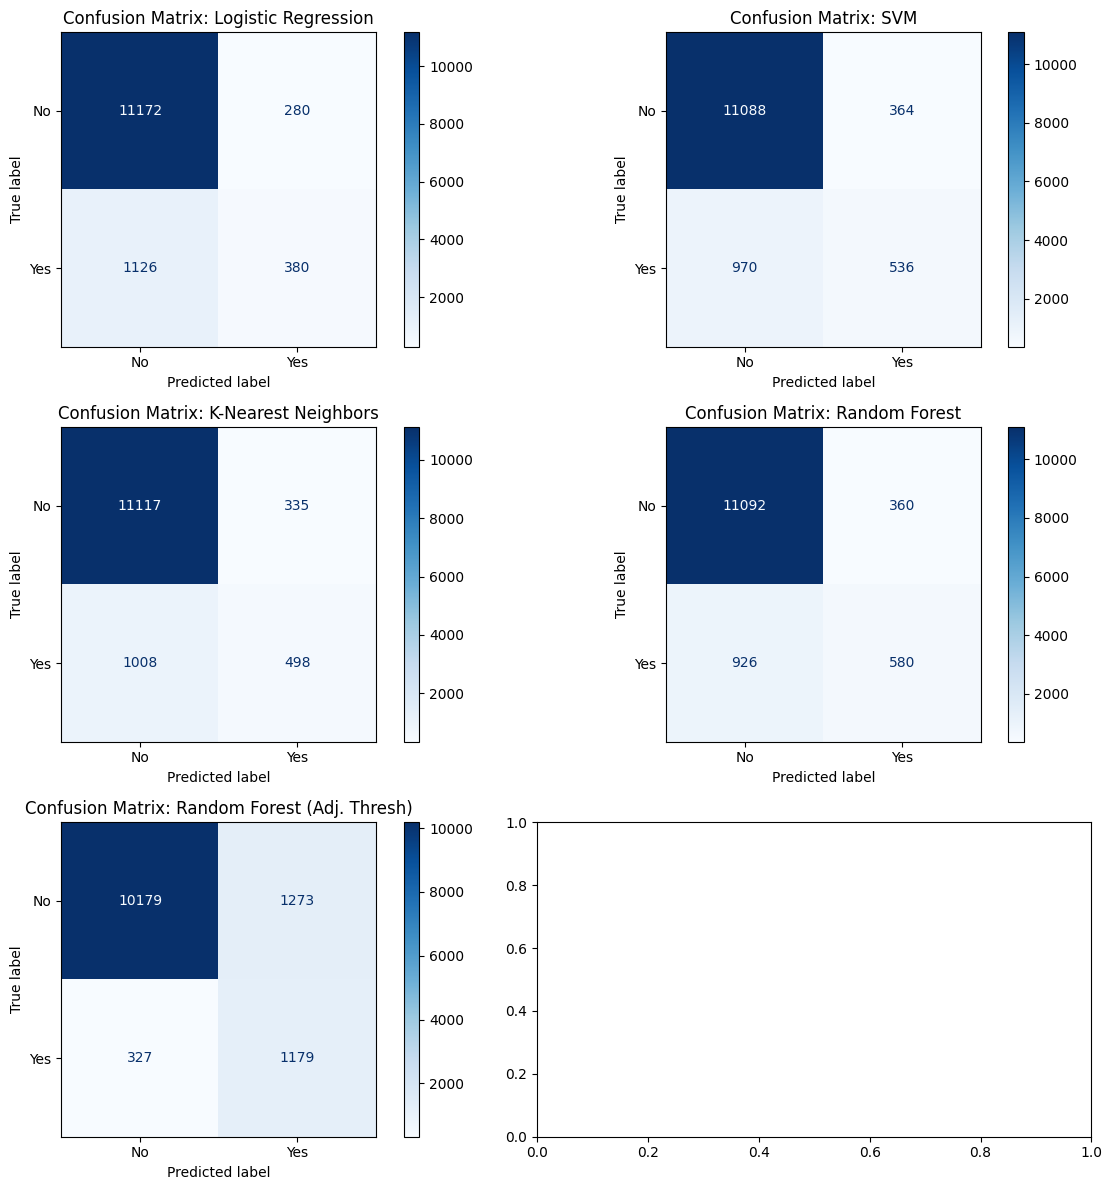

In [ ]:
models_with_adjusted = models.copy()
models_with_adjusted['Random Forest (Adj. Thresh)'] = None  # Placeholder for logic below

# Total number of models
n_models = len(models_with_adjusted)
cols = 2
rows = int(np.ceil(n_models / cols))

# Create subplots dynamically
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
axes = axes.flatten()

for idx, (name, model) in enumerate(models_with_adjusted.items()):
    if name == 'Random Forest (Adj. Thresh)':
        y_pred = (rf_model.predict_proba(X_test)[:, 1] >= 0.25).astype(int)
    else:
        y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(ax=axes[idx], values_format='d', cmap='Blues')
    axes[idx].set_title(f"Confusion Matrix: {name}")
    print(model,cm)
plt.tight_layout()
plt.show()


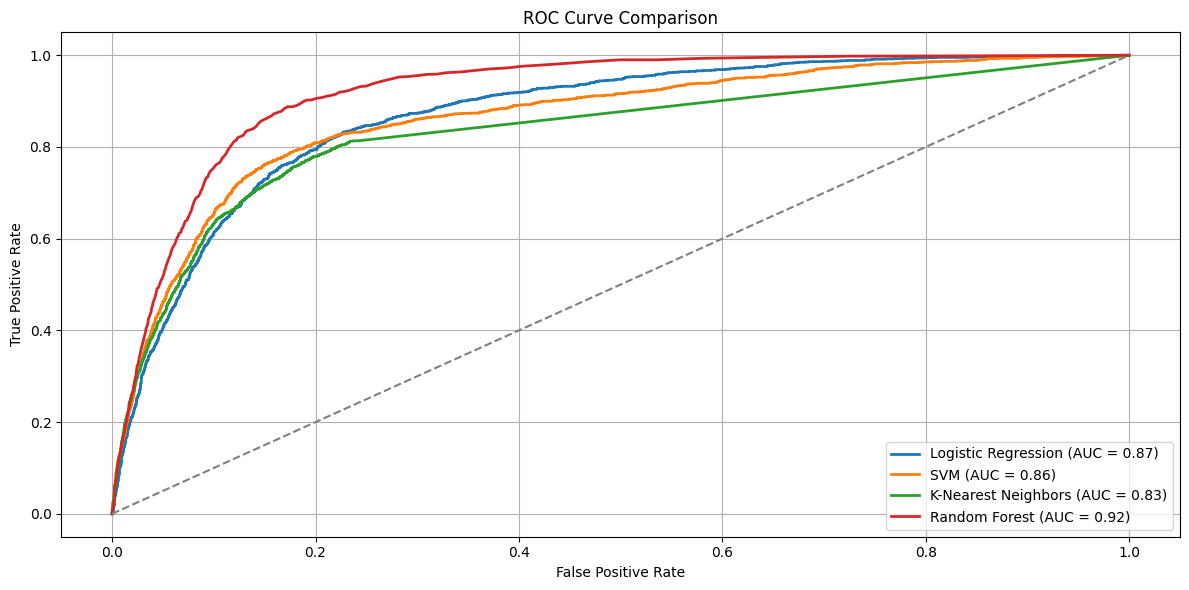

In [ ]:
plt.figure(figsize=(12, 6))
for name, model in models.items():
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


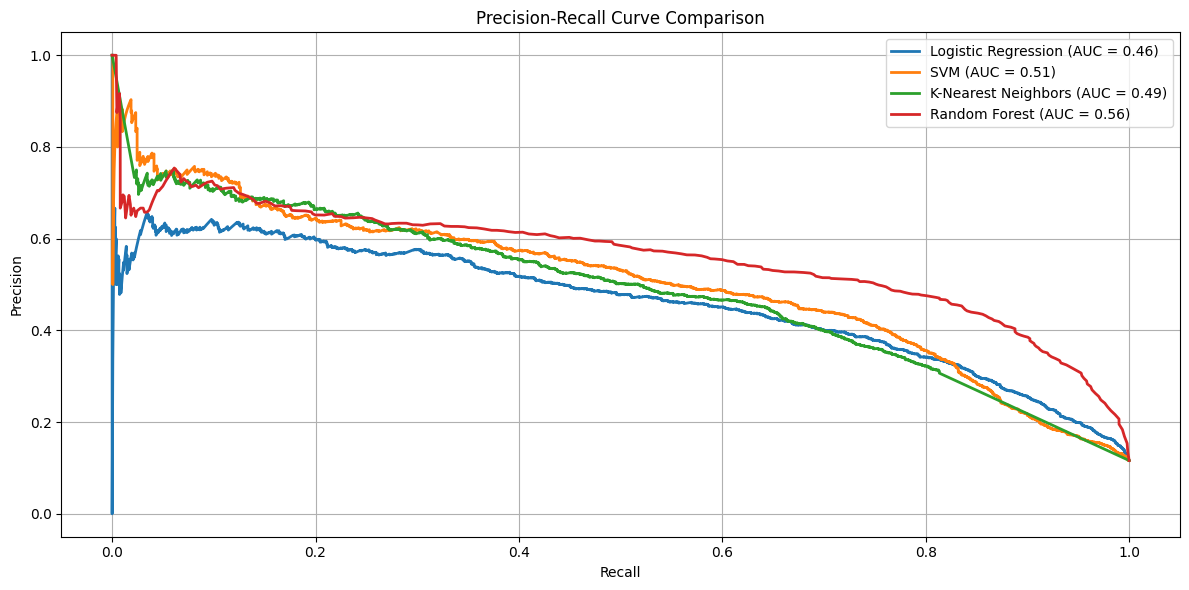

In [ ]:
# Initialize plot for Precision-Recall curves
plt.figure(figsize=(12, 6))
for name, model in models.items():
    y_score = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f'{name} (AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-40-904002063.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features, y=importances, palette="viridis")


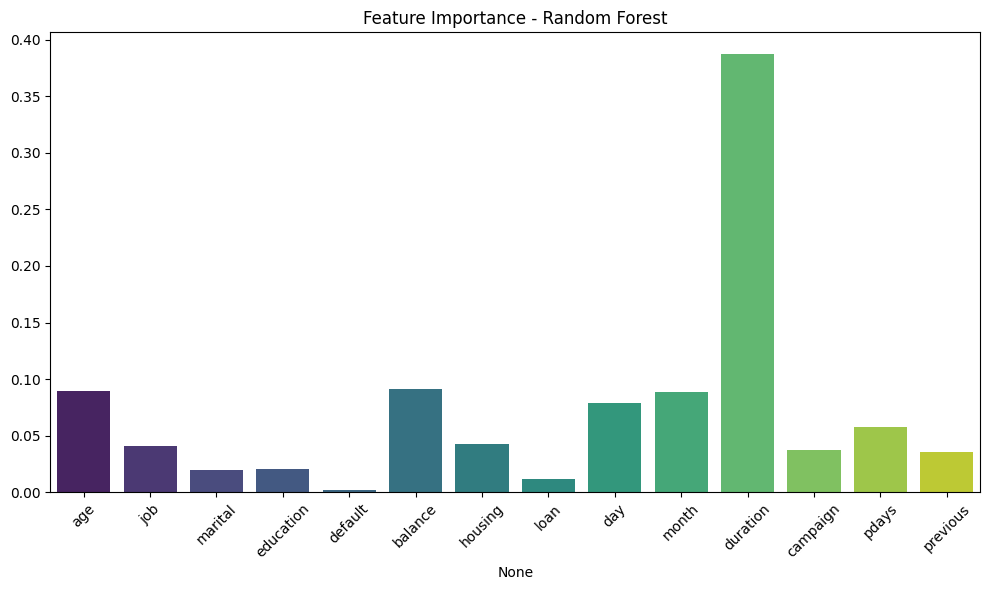

In [ ]:
importances = rf_model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=importances, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
